<a href="https://colab.research.google.com/github/wayne0git/tensorflow_basic/blob/main/tflite/model_maker/tflite_model_maker_classification_example.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# TensorFlow Lite Model Maker - Image Classification Example
- Ref : https://learnopencv.com/tensorflow-lite-model-maker-create-models-for-on-device-machine-learning/

## Environment Preparation

In [ ]:
# Intall TF Lite Model Maker Library
!pip install tflite-model-maker

In [ ]:
# Install PortAudio library (For tflite_model_maker)
!apt-get install libportaudio2

## Dataset Preparation

In [ ]:
# Download Cat & Dog dataset
!wget --no-check-certificate "https://download.microsoft.com/download/3/E/1/3E1C3F21-ECDB-4869-8368-6DEBA77B919F/kagglecatsanddogs_5340.zip" -O "/content/cats-and-dogs.zip"

In [ ]:
# Unzip data
!unzip /content/cats-and-dogs.zip -d /content

In [14]:
# Remove corrupted images
!rm /content/PetImages/Cat/666.jpg
!rm /content/PetImages/Dog/11702.jpg 

In [ ]:
# JPG =>  PNG
import os
from PIL import Image
from tqdm import tqdm

INPUT_DIR = '/content/PetImages'
OUT_DIR = '/content/dataset'

for dirpath, dirnames, filenames in os.walk(INPUT_DIR):
    img_names = [fn for fn in filenames if os.path.splitext(fn)[1] in ['.jpg', '.jpeg']]

    for fn in tqdm(img_names):
        out_folder = os.path.basename(dirpath)
        out_fname = os.path.splitext(fn)[0] + '.png'
        if not os.path.isdir(os.path.join(OUT_DIR, out_folder)):
            os.makedirs(os.path.join(OUT_DIR, out_folder))
        Image.open(os.path.join(dirpath, fn)).convert('RGB').save(os.path.join(OUT_DIR, out_folder, out_fname))

## Import Library

In [22]:
import os
import numpy as np
import matplotlib.pyplot as plt

In [23]:
import tensorflow as tf
assert tf.__version__.startswith('2')

In [27]:
from tflite_model_maker import model_spec
from tflite_model_maker import image_classifier
from tflite_model_maker.config import ExportFormat
from tflite_model_maker.config import QuantizationConfig
from tflite_model_maker.image_classifier import DataLoader

## Parameter

In [28]:
# Data
DATA_DIR = '/content/dataset'
MODEL_DIR = '/content/model'

## Load Data

In [29]:
# Load data for image classificaition
data = DataLoader.from_folder(DATA_DIR)

INFO:tensorflow:Load image with size: 24998, num_label: 2, labels: Cat, Dog.


In [30]:
# Split data (Train : 70%, Validation: 20%, Test: 10%)
train_data, rest_data = data.split(0.7)
validation_data, test_data = rest_data.split(0.67)

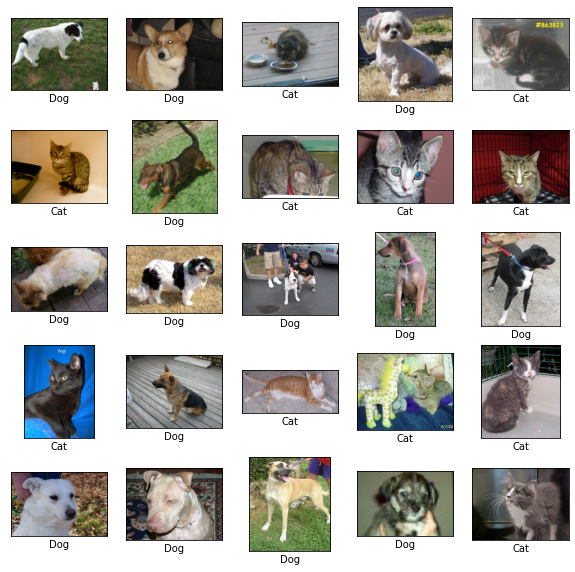

In [40]:
# Visualization
plt.figure(figsize=(10,10))

for i, (image, label) in enumerate(data.gen_dataset().unbatch().take(25)):
	  plt.subplot(5, 5, i+1)
	  plt.xticks([])
	  plt.yticks([])
	  plt.grid(False)
	  plt.imshow(image.numpy(), cmap=plt.cm.gray)
	  plt.xlabel(data.index_to_label[label.numpy()])

plt.show()

## Train Model

In [ ]:
model = image_classifier.create(train_data,\
                                validation_data=validation_data,\
                                model_spec=model_spec.get('efficientnet_lite0'),\
                                train_whole_model=True)

## Convert Model

In [ ]:
# FP 16 Quantization
config = QuantizationConfig.for_float16()
model.export(export_dir=MODEL_DIR, tflite_filename='model_fp16.tflite', quantization_config=config)

In [ ]:
# Dynamic Quantization
config = QuantizationConfig.for_dynamic()
model.export(export_dir=MODEL_DIR, tflite_filename='model_dynamic.tflite', quantization_config=config)

In [ ]:
# Integer Quantization
config = QuantizationConfig.for_int8(validation_data)
model.export(export_dir=MODEL_DIR, tflite_filename='model_int8.tflite', quantization_config=config)

## Evaluate Model

In [46]:
# Original Model
loss, accuracy = model.evaluate(test_data)

78/78 [==============================] - 114s 295ms/step - loss: 0.2164 - accuracy: 0.9915


In [ ]:
# Optimized Model
model.evaluate_tflite(os.path.join(MODEL_DIR, 'model_fp16.tflite'), test_data)
model.evaluate_tflite(os.path.join(MODEL_DIR, 'model_dynamic.tflite'), test_data)
model.evaluate_tflite(os.path.join(MODEL_DIR, 'model_int8.tflite'), test_data)